In [1]:
import warnings; warnings.simplefilter('ignore')

import torch
import os
import time
import itertools
import collections
import torch.nn as nn
from cell import graph_utils, utils
from cell.Word2vec import prepare_vocab, dataloader, wv
from stellargraph import StellarGraph
from torch.nn import functional as F
from stellargraph.data import BiasedRandomWalk
import cell.BiasedDirectedWeightedWalk as BDWW
from stellargraph import StellarDiGraph
from IPython.display import Image
from numpy.random import multinomial



os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import imp
from cell import  utils, analysis, plot_utils
from cell.Word2vec import prepare_vocab, dataloader, wv


imp.reload(utils)
imp.reload(prepare_vocab)

<module 'cell.Word2vec.prepare_vocab' from '/Users/fahimehb/Documents/git-workspace/celltypes/cell/Word2vec/prepare_vocab.py'>

In [3]:
def plot_grid(filepath, prefix_filename ,figsize, w_list, plot_dim, annotation, E_color, R_color, E_marker, R_marker):
    
    fig = plt.figure(figsize=figsize)
    i=1
    for w in w_list:
        filename = "w" + str(w) + "_" + str(plot_dim) + "d.csv"
        print(filepath + prefix_filename + "R_" + filename)
        if prefix_filename:
            R = pd.read_csv(filepath + prefix_filename + "R_" + filename, index_col="Unnamed: 0")
            E = pd.read_csv(filepath + prefix_filename + "E_" + filename, index_col="Unnamed: 0")
        else:
            R = pd.read_csv(filepath  + "R_" + filename, index_col="Unnamed: 0")
            E = pd.read_csv(filepath  + "E_" + filename, index_col="Unnamed: 0")
            
        E.index = E.index.astype('str')
        R.index = R.index.astype('str')
        R = R.loc[[str(j) for j in np.sort([int(i) for i in R.index])]]
        E = E.loc[[str(j) for j in np.sort([int(i) for i in E.index])]]
        
        data = pd.concat((E, R))
        lim1 = np.floor(np.min(pd.concat((data['Z0'], data['Z1']))))
        lim2 = np.ceil(np.max(pd.concat((data['Z0'], data['Z1']))))
        
        if plot_dim == 3:
            ax = fig.add_subplot(len(w_list), 3, i, projection="3d")
            ax.scatter(E['Z0'], E['Z1'], E['Z2'], c = E_color, s=30, marker=E_marker, label='E')
            ax.scatter(R['Z0'], R['Z1'], R['Z2'], c = R_color, s=30, marker=R_marker, label='R')
            if annotation:
                for j, txt in enumerate(data.index.tolist()):
                    ax.text(data['Z0'][j], data["Z1"][j], data['Z2'][j], txt, size=10)
            ax.set_zlim(lim1, lim2)
        
        else:
            ax = fig.add_subplot(len(w_list), 3, i)
            ax.scatter(E['Z0'], E['Z1'], c = E_color, s=30, marker=E_marker, label="E")
            ax.scatter(R['Z0'], R['Z1'], c = R_color, s=30, marker=R_marker, label="R")
            if annotation:
                for j, txt in enumerate(data.index.tolist()):
                    ax.text(data['Z0'][j], data["Z1"][j], txt, size=10)
        
        title = "w=" + str(w) 
        ax.set_title(title)
        i = i + 1
        ax.set_xlim(lim1, lim2)
        ax.set_ylim(lim1, lim2)

    plt.legend()
    plt.show()

In [4]:
def word_counts(corpus):
    return dict(collections.Counter(list(itertools.chain.from_iterable(corpus))))

def negative_sample_probability(word_counts):
    sample_probability = {}
    normalizing_factor = sum([v**0.75 for v in word_counts.values()])
    for word in word_counts:  
        sample_probability[word] = word_counts[word]**0.75 / normalizing_factor
    return sample_probability

def sample_negative(sample_probability, sample_size, word_counts):
    words = np.array(list(word_counts.keys()))
    while True:
        word_list = []
        sampled_index = np.array(multinomial(sample_size, list(sample_probability.values())))
        for index, count in enumerate(sampled_index):
            for _ in range(count):
                 word_list.append(words[index])
        return word_list

In [5]:
# word_c = word_counts(corpus)
# sample_probability = negative_sample_probability(word_c)
# words = np.array(list(word_c.keys()))
# for j in range(10):
#     word_list = []
#     sampled_index = np.array(multinomial(4, list(sample_probability.values())))
#     for index, count in enumerate(sampled_index):
#         for _ in range(count):
#                 word_list.append(words[index])
#     print(word_list)
# sample_probability

In [6]:
def emitter_receiver_negative_tuples(corpus, window, n_neg):
    emitter_tuple_list = []
    receiver_tuple_list = []
    word_c = word_counts(corpus)
    sample_probability = negative_sample_probability(word_c)
    for text in corpus:
        for i, word in enumerate(text):
            first_context_word_index = max(0, i - window)
            last_context_word_index = min(i + window + 1 , len(text))
            if (i >= window) & (i<len(text)- window):
                emitter_negs = sample_negative(sample_probability, n_neg, word_c)
                receiver_negs = sample_negative(sample_probability, n_neg, word_c)
            
                pos_neg_examples = (word,)
                for j in range(first_context_word_index, i):
                    pos_neg_examples = pos_neg_examples + (text[j],)
                for neg in emitter_negs:
                    pos_neg_examples = pos_neg_examples + (neg,)
                emitter_tuple_list.append(pos_neg_examples)
            
                pos_neg_examples = (word,)
                for j in range(last_context_word_index-1, i, -1):
                    pos_neg_examples = pos_neg_examples + (text[j],)
                for neg in receiver_negs:
                    pos_neg_examples = pos_neg_examples + (neg,)
                receiver_tuple_list.append(pos_neg_examples)
    return emitter_tuple_list, receiver_tuple_list

In [7]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)
    
def build_data_loader(datasets, batch_size, shuffle=True, drop_last=True, num_workers=0):
    data_loader = torch.utils.data.DataLoader(
        ConcatDataset(*[datasets[k][0] for k in datasets.keys()]),
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers)
    return {k: i for i, k in enumerate(datasets.keys())}, data_loader

In [8]:
# path_to_walk = "/Users/fahimehb/Documents/NPP_GNN_project/dat/walk_weighted_directed_footbal_v2.csv"
# corpus= utils.read_list_of_lists_from_csv(path_to_walk)

length = 10000
p = 1
q = 1
N = 1
walk_filename = "walk_node21_32_removed.csv"
roi = "VISp"
project_name = "NPP_GNN_project"
layer_class = "single_layer"
layer = "base_unnormalized_allcombined"
walk_type= "Directed_Weighted_node2vec"

walk_dir = utils.get_walk_dir(roi,
                              project_name,
                              N,
                              length,
                              p,
                              q,
                              layer_class,
                              layer,
                              walk_type)

corpus = utils.read_list_of_lists_from_csv(os.path.join(walk_dir, walk_filename))

emitter_tuples, receiver_tuples = emitter_receiver_negative_tuples(corpus, window=1, n_neg=5)

vocabulary = prepare_vocab.get_vocabulary(corpus)
word_2_index = prepare_vocab.get_word2idx(vocabulary, padding=False)
index_2_word = prepare_vocab.get_idx2word(vocabulary, padding=False)

In [11]:
keysnodes = len(vocabulary)
n_nodes = 91
datasets = {}

datasets['E'] = []
emitter_dataset = dataloader.EmitterReceiverNegativeDataset_debug(tuples_list=emitter_tuples,
                                                                  wd_2_idx=word_2_index,
                                                                  n_pos=1, 
                                                                  n_neg=5)
datasets['E'].append(emitter_dataset)
datasets['E'].append(n_nodes)


datasets['R'] = []
receiver_dataset = dataloader.EmitterReceiverNegativeDataset_debug(tuples_list=receiver_tuples,
                                                                  wd_2_idx=word_2_index,
                                                                  n_pos=1, 
                                                                  n_neg=5)
datasets['R'].append(receiver_dataset)
datasets['R'].append(n_nodes)

keys, data_loader = build_data_loader(datasets, batch_size=2000, shuffle=False)

In [12]:
class EmitterReceiverNegativeCoupled(nn.Module):
    """
    """
    def __init__(self, n_nodes=[93], embedding_size=2, n_arms=1):
        """
        """
        super(EmitterReceiverNegativeCoupled, self).__init__()
        self.n_nodes = n_nodes
        self.embedding_size = embedding_size
        self.n_arms = n_arms

        self.embeddings = nn.ModuleList([nn.Embedding(n_nodes[i], embedding_size) for i in range(n_arms)])
        self.linear = nn.ModuleList([nn.Linear(embedding_size,  n_nodes[i], bias=False) for i in range(n_arms)])
        self.softmax = nn.Softmax()

    def encoder(self, query_node, pos_nodes, neg_nodes, arm):
        q = self.embeddings[arm](query_node)
        p = self.embeddings[arm](pos_nodes).squeeze(1)
        if neg_nodes.shape[2] > 0:
            n = self.embeddings[arm](neg_nodes).squeeze(1)
        else :
            n = neg_nodes
        return q, p, n

    def forward(self, query_node, pos_nodes, neg_nodes):
        q_embedding = [None] * self.n_arms
        p_embeddings = [None] * self.n_arms
        n_embeddings = [None] * self.n_arms

        for arm in range(self.n_arms):
            q, p, n = self.encoder(query_node[arm], pos_nodes[arm], neg_nodes[arm], arm)
            q_embedding[arm] = q
            p_embeddings[arm] = p
            n_embeddings[arm] = n
        return q_embedding, p_embeddings, n_embeddings
    
    
    
def loss_emitter_receiver_negative_independent(q_embedding, p_embedding, n_embedding, n_arms):
    mean_pos_dist_squared = 0
    mean_neg_dist_squared = 0

    for arm in range(n_arms):
        other_arm = arm * -1 + 1
        pos_dist = q_embedding[arm] - p_embedding[other_arm]
        pos_dist_squared = (torch.norm(pos_dist, dim=2))**2
        mean_pos_dist_squared = mean_pos_dist_squared + torch.mean(pos_dist_squared)
        
        neg_dist = q_embedding[arm] - n_embedding[other_arm]
        neg_dist_squared = (torch.norm(neg_dist, dim=2))**2
        mean_neg_dist_squared = mean_neg_dist_squared +torch.mean(neg_dist_squared)

    mean_pos_dist_squared = mean_pos_dist_squared / n_arms
    mean_neg_dist_squared = mean_neg_dist_squared / n_arms
    
    loss = F.relu(mean_pos_dist_squared - mean_neg_dist_squared + 1)
    
    return mean_pos_dist_squared, mean_neg_dist_squared, loss

In [13]:
batch_size=2000
n_pos = 1
n_neg = 5
learning_rate = 0.01
embedding_size = 2
n_arms = 2
n_epochs = 10

model = EmitterReceiverNegativeCoupled(embedding_size=embedding_size,
                                     n_nodes=[v[1] for (k, v) in datasets.items()],
                                     n_arms=n_arms).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

training_loss = []
for epoch in range(n_epochs):
    losses = []
    t0 = time.time()
    for batch_idx, all_data in enumerate(data_loader):
        query_node = [data[0].to(device) for data in all_data]
        pos_nodes = [data[1].to(device) for data in all_data]
        neg_nodes = [data[2].to(device) for data in all_data]

        query_node = [torch.reshape(query_node[i], (batch_size, 1)) for i in range(len(query_node))]
        pos_nodes = [torch.reshape(pos_nodes[i], (batch_size, 1, n_pos)) for i in range(len(pos_nodes))]
        neg_nodes = [torch.reshape(neg_nodes[i], (batch_size, 1, n_neg)) for i in range(len(neg_nodes))]
        
        optimizer.zero_grad()
        q_embedding, p_embedding, n_embedding = model(query_node, pos_nodes, neg_nodes)
        pos_dist, neg_dist, loss = loss_emitter_receiver_negative_independent(q_embedding, 
                                                                              p_embedding,
                                                                              n_embedding,
                                                                              n_arms)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    training_loss.append(np.mean(losses))
    print(f'epoch: {epoch + 1}/{n_epochs}, loss:{np.mean(losses):.4f}')
    print(f'pos_dist: {pos_dist:.4f}, neg_dist:{neg_dist:.4f}')


epoch: 1/10, loss:0.3355
pos_dist: 8.3004, neg_dist:9.3872
epoch: 2/10, loss:0.0000
pos_dist: 8.3827, neg_dist:9.4949
epoch: 3/10, loss:0.0000
pos_dist: 8.3827, neg_dist:9.4949
epoch: 4/10, loss:0.0000
pos_dist: 8.3827, neg_dist:9.4949
epoch: 5/10, loss:0.0000
pos_dist: 8.3827, neg_dist:9.4949
epoch: 6/10, loss:0.0000
pos_dist: 8.3827, neg_dist:9.4949
epoch: 7/10, loss:0.0000
pos_dist: 8.3827, neg_dist:9.4949
epoch: 8/10, loss:0.0000
pos_dist: 8.3827, neg_dist:9.4949
epoch: 9/10, loss:0.0000
pos_dist: 8.3827, neg_dist:9.4949
epoch: 10/10, loss:0.0000
pos_dist: 8.3827, neg_dist:9.4949


In [ ]:
# print([index_2_word[i] for i in all_data[0][0].numpy()][0:10])
# print([index_2_word[i] for i in all_data[1][0].numpy()][0:10])

In [ ]:
# print([index_2_word[i] for i in all_data[0][1].squeeze(1).numpy()][0:10])
# print([index_2_word[i] for i in all_data[1][1].squeeze(1).numpy()][0:10])

In [ ]:
# print([index_2_word[i] for i in all_data[0][2].squeeze(1).numpy()][0:10])
# print([index_2_word[i] for i in all_data[1][2].squeeze(1).numpy()][0:10])

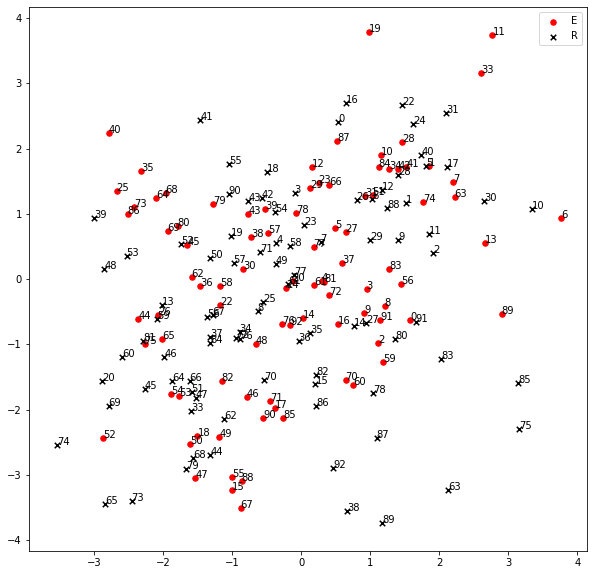

In [14]:
E = model.embeddings[0].weight.detach().numpy()
E = pd.DataFrame(E, columns=["Z"+str(i) for i in range(embedding_size)], index=index_2_word.values())
E.index = E.index.astype('str')

R = model.embeddings[1].weight.detach().numpy()
R = pd.DataFrame(R, columns=["Z"+str(i) for i in range(embedding_size)], index=index_2_word.values())
R.index = R.index.astype('str')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()

ax.scatter(E['Z0'], E['Z1'], c = 'Red', s=30, marker='o', label="E")
for j, txt in enumerate(E.index.tolist()):
    ax.text(E['Z0'][j], E["Z1"][j], txt, size=10)

ax.scatter(R['Z0'], R['Z1'], c = "black", s=30, marker='x', label="R")
for j, txt in enumerate(R.index.tolist()):
    ax.text(R['Z0'][j], R["Z1"][j], txt, size=10)

ax.legend()
plt.show()

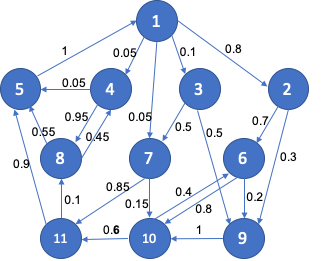

In [33]:
Image("/Users/fahimehb/Documents/NPP_GNN_project/code/directed_weighted_footbal_4_3_3_v2.png", width=400, height=50)

In [ ]:
outd = [1 , 1 ]

In [48]:
R = model.embeddings[1].weight.detach().numpy()
R = pd.DataFrame(R, columns=["Z"+str(i) for i in range(embedding_size)], index=index_2_word.values())
R.index = R.index.astype('str')
R.index = ["R_" + i for i in R.index.tolist()]


E = model.embeddings[0].weight.detach().numpy()
E = pd.DataFrame(E, columns=["Z"+str(i) for i in range(embedding_size)], index=index_2_word.values())
E.index = E.index.astype('str')
E.index = ["E_" + i for i in E.index.tolist()]

data = pd.concat((E,R))
analysis.get_closest_nodes(emb=data, index=data.index.tolist(), node='E_2', topn=10)

E_2      0.000000
R_1     19.351858
E_5     20.569129
R_6     23.622349
R_9    118.784781
E_3    121.180244
R_2    122.886861
R_3    123.100781
R_7    123.237348
E_1    123.475998
Name: E_2, dtype: float64

In [18]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(m(input), target)


In [19]:
output

tensor(1.1434, grad_fn=<BinaryCrossEntropyBackward>)

In [20]:
input

tensor([ 0.1244, -0.8119,  1.2394], requires_grad=True)

In [21]:
target

tensor([0., 1., 0.])